##Classify Radio Signals from Outer Space with Keras

## Import Libraries

In [0]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Load and Preprocess SETI Data

In [0]:
train_images = pd.read_csv("dataset/train/images.csv" , header = None)
train_labels = pd.read_csv("dataset/train/labels.csv" , header = None)

val_images = pd.read_csv("dataset/validation/images.csv" , header = None)
val_labels = pd.read_csv("dataset/validation/labels.csv" , header = None)

In [0]:
train_images.head(3)

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510


In [0]:
train_labels.head(3)

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0


In [0]:
print("Training set shape:" , train_images.shape , train_labels.shape)
print("Validation set shape" , val_images.shape , val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape (800, 8192) (800, 4)


In [0]:
x_train = train_images.values.reshape(3200 , 64 , 128 , 1)
x_val = val_images.values.reshape(800 , 64 , 128 , 1)

y_train = train_labels.values
y_val = val_labels.values

##Plot 2D Spectrograms

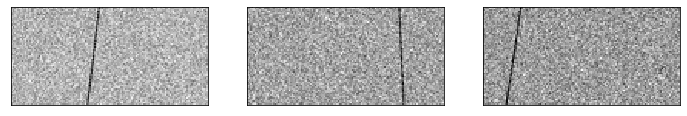

In [0]:
plt.figure(0 , figsize = (12 , 12))
for i in range(1 , 4):
    plt.subplot(1 , 3 , i)
    img = np.squeeze(x_train[np.random.randint(0 , x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img , cmap = "gray")

##Create Training and Validation Data Generators

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip = True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip = True)
datagen_val.fit(x_val)

##Creating the CNN Model

In [0]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
# Initialising the CNN
model = Sequential()
# 1st Convolution
model.add(Conv2D(32 , (5 , 5) , padding = "same" , input_shape = (64 , 128 , 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2 , 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64 , (5 , 5) , padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2 , 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))

model.add(Dense(4 , activation="softmax"))

##Learning Rate Scheduling and Compile the Model

In [0]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate = initial_learning_rate,
                decay_steps = 5,
                decay_rate = 0.96,
                staircase = True
)
optimizers = Adam(learning_rate = lr_schedule)

In [0]:
model.compile(optimizer = optimizers , loss = "categorical_crossentropy" , metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_4 (Activation)    (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 64, 64)       

## Task 7: Training the Model

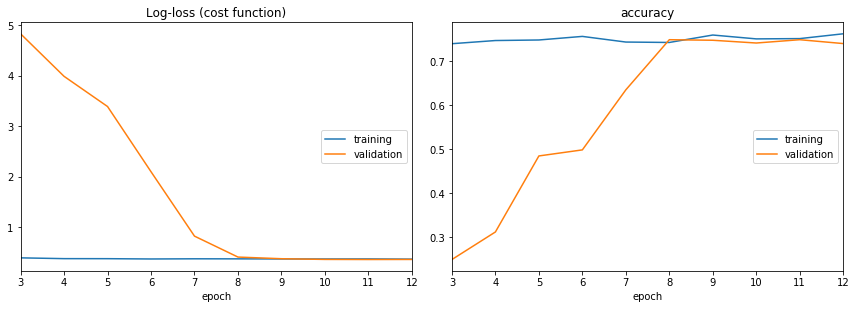

Log-loss (cost function):
training   (min:    0.370, max:    0.553, cur:    0.370)
validation (min:    0.363, max:    4.829, cur:    0.364)

accuracy:
training   (min:    0.702, max:    0.762, cur:    0.762)
validation (min:    0.244, max:    0.749, cur:    0.740)
100/100 [==============================] - 6s 56ms/step - loss: 0.3704 - accuracy: 0.7622 - val_loss: 0.3640 - val_accuracy: 0.7400


In [0]:
checkpoint = ModelCheckpoint("model_weight.h5" , monitor = "val_loss" , save_weights_only = True,
                            mode = "min" , verbose = 0)
callbacks = [PlotLossesCallback() , checkpoint]

batch_size = 32

history = model.fit(
        datagen_train.flow(x_train , y_train , batch_size = batch_size , shuffle = True),
        steps_per_epoch = len(x_train) // batch_size,
        validation_data = datagen_val.flow(x_val , y_val , batch_size = batch_size , shuffle = True),
        validation_steps = len(x_val) // batch_size,
        epochs = 12,
        callbacks = callbacks
)

## Task 8: Model Evaluation

In [0]:
model.evaluate(x_val , y_val)

800/800 [==============================] - 1s 645us/sample - loss: 0.3629 - accuracy: 0.7375


[0.3628942335210741, 0.7375]

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val , 1)
y_pred = np.argmax(model.predict(x_val) , 1)
print(metrics.classification_report(y_true , y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.48      0.58      0.53       200
           2       0.47      0.39      0.42       200
           3       1.00      1.00      1.00       200

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800



In [0]:
print("Classification Accuracy: %0.6f" % metrics.accuracy_score(y_true , y_pred))

Classification Accuracy: 0.737500
